In [3]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import numpy as np
import cv2 as cv
import glob

In [2]:
# Helper functions
def BGR2RGB(img):
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

def DisplayImage(img, title):
    plt.figure()
    plt.imshow(BGR2RGB(img))
    plt.title(title)

## Undistort Chessboard Images

In [19]:
def undistortChessboard(images):
    imgpoints = []
    termCriteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Iterate through each chessboard image
    for imagePath in images:
        img = cv.imread(imagePath)
        
        # Convert the image to grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        # Find chessboard corners
        patternSizeVal = 5
        retval = False
        
        while(retval == False):
            retval, corners = cv.findChessboardCorners(gray, (patternSizeVal, 6), None)
            if retval:
                cornerSP = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), termCriteria)
                imgpoints.append(corners)
            
                # Display the corners
                cv.drawChessboardCorners(img, (7,6), cornerSP, retval)
                DisplayImage(img, imagePath)
            else:
                # Increase pattern size and try again
                patternSizeVal = patternSizeVal + 1
                if(patternSizeVal > 9):
                    retval = True
                    print("Could not find corners in " + imagePath)

Could not find corners in materials/camera_cal/calibration1.jpg


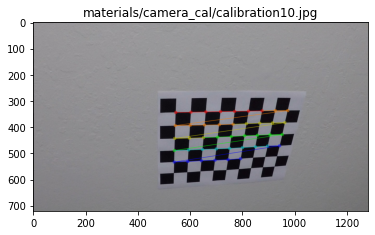

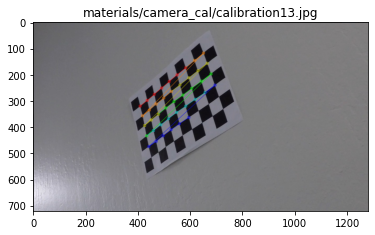

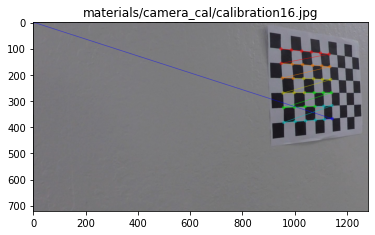

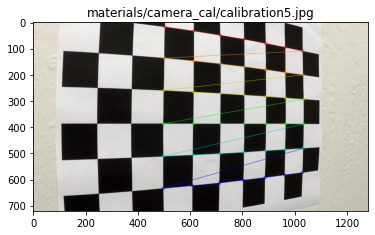

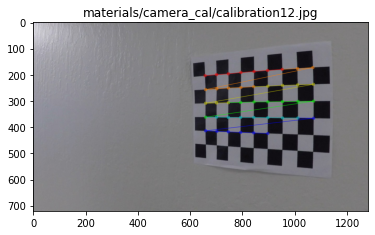

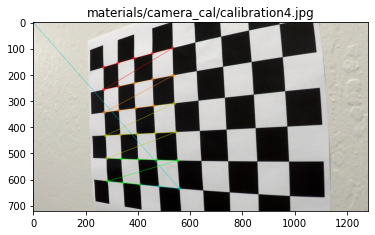

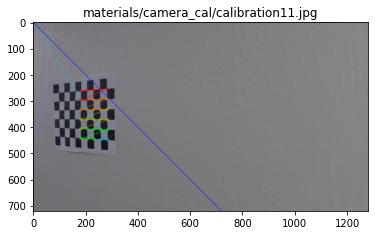

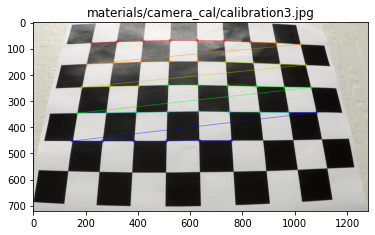

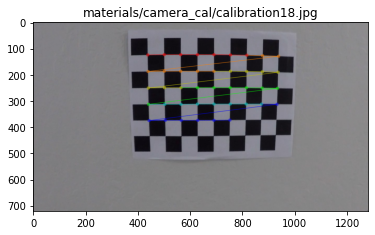

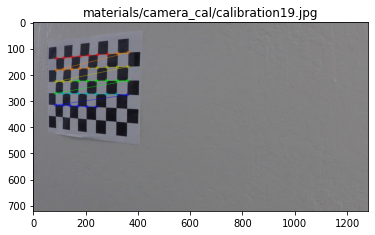

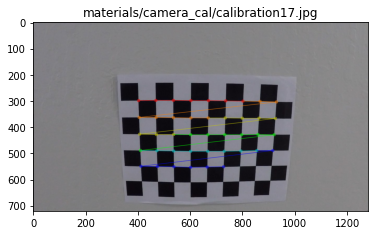

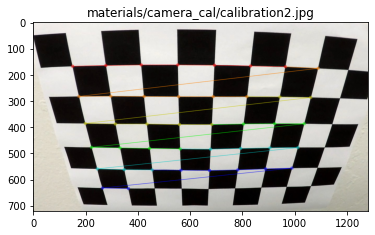

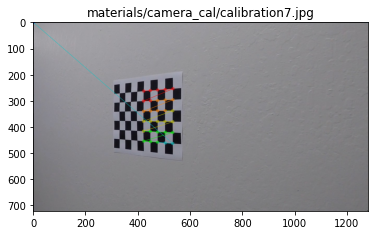

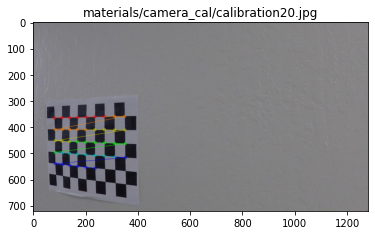

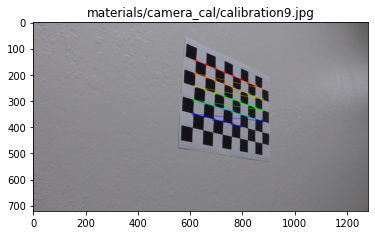

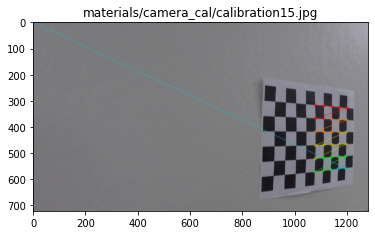

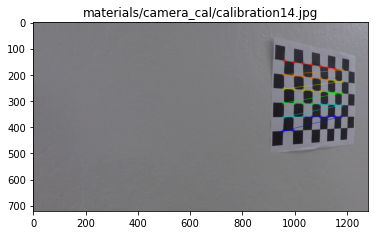

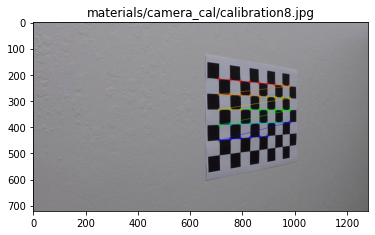

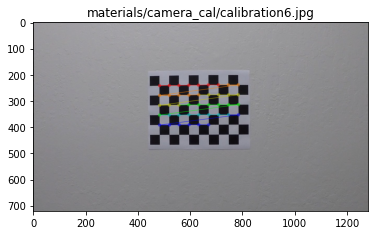

In [20]:
image_paths = glob.glob('materials/camera_cal/calibration*.jpg')
undistortChessboard(image_paths)